## Imports

In [1]:
import os
import re

from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
import torch

In [2]:
import nltk

from nltk.corpus import webtext
# from nltk.tokenize import TweetTokenizer
from nltk.tokenize import sent_tokenize

## Global Variables

In [3]:
DEVICE = "cuda:0"
assert torch.cuda.is_available()


PADDING_TOKEN = 'PAD' # voc 0
UNKNOWN_TOKEN = 'UKN' # voc 1

MAX_SEQ_LEN = 10

BATCH_SIZE = 16
EMB_SIZE = 128

VAL_SPLIT = 0.2
TEST_SPLIT = 0.1

# for reproducibility
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
torch.manual_seed(0)

## Vocabulary

In [4]:
class Vocabulary():
    def __init__(
        self, 
        text,
        max_sentence_length : int = 32,
        padding_token : str = PADDING_TOKEN,
        unknown_token : str = UNKNOWN_TOKEN
    ):
        self.padding_token = padding_token
        self.unknown_token = unknown_token
        self.sentences = Vocabulary.prepare_sentences(text, max_sentence_length)
        self.build_vocab()
        
    @staticmethod
    def text_cleaning(string):
        string = re.sub('-\n', '', string)
        string = re.sub(r"""[*#@&%£ö'ä$ü¨~^)('+°¢./><$\[\]`]""", '', string)
        string = re.sub('[0-9]', '', string)
        return re.sub('\n', ' ', string)
    
    @staticmethod
    def prepare_sentences(text, max_sentence_length):
        sentences = sent_tokenize(text)
        sentences = [re.sub(r".*: ", '', sent, 1) for sent in sentences]
        sentences = [Vocabulary.text_cleaning(sentence) for sentence in sentences]
        sentences = [[w.lower() for w in nltk.word_tokenize(sentence)] for sentence in sentences]
        return [sent for sent in sentences if len(sent) < max_sentence_length]
    
    def build_vocab(self):
        vocab = {}
        for tokens in self.sentences:
            for token in tokens:
                if token in vocab.keys():
                    vocab[token] += 1
                else:
                    vocab[token] = 1

        self.vocab = {k: v for k, v in sorted(vocab.items(), key=lambda item: -item[1])}

        self.word_to_idx = {k : (i+2) for i,(k,_) in enumerate(vocab.items())}
        self.word_to_idx[self.padding_token] = 0
        self.word_to_idx[self.unknown_token] = 1
        self.idx_to_word = {v : k for k, v in self.word_to_idx.items()}
        
    def get_vocab_size(self):
        return len(self.vocab)
    
    def pad_and_truncate(self, tokens, max_length):
        diff = max_length - len(tokens)
        if diff < 0:
            return tokens[:max_length]
        else:
            return tokens + [self.word_to_idx[self.padding_token]] * diff

In [5]:
txt = webtext.raw('overheard.txt')
voc = Vocabulary(txt)

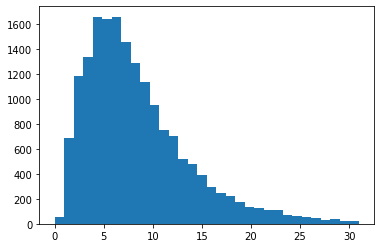

In [6]:
plt.hist([len(sent) for sent in voc.sentences], bins = 32)
plt.show()

In [7]:
class LM_dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        vocabulary : Vocabulary,
        max_length : int
    ):
        self.vocabulary = vocabulary
        self.max_length = max_length
        self.indices = [
            self.vocabulary.pad_and_truncate([self.get_idx(w) for w in sentence], max_length + 1)
            for sentence in vocabulary.sentences if len(sentence) > 1
        ]
        
    def get_idx(self, token):
        try:
            return self.vocabulary.word_to_idx[token]
        except KeyError:
            return self.vocabulary.word_to_idx[self.vocabulary.unknown_token]
        
    def __getitem__(self, idx):
        indices = self.indices[idx]
        return (
            torch.tensor(indices[:self.max_length]).to(DEVICE),
            torch.tensor(indices[1:self.max_length+1]).to(DEVICE)
        )
        
    def __len__(self):
        return len(self.indices)

In [8]:
train_dataset = LM_dataset(
    voc,
    MAX_SEQ_LEN + 1
)

In [9]:
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size = BATCH_SIZE,
    shuffle = False,
    pin_memory = False,
    drop_last = True
)

In [10]:
emb_layer = torch.nn.Embedding(
    voc.get_vocab_size(),
    EMB_SIZE
).to(DEVICE)

In [11]:
lstm = torch.nn.LSTM(
    input_size = EMB_SIZE,
    hidden_size = 20,
    num_layers = 2,
    batch_first = True
).to(DEVICE)

In [19]:
class NextWordPredictorModel(torch.nn.Module):
    def __init__(
        self,
        emb_dim : int,
        vocab_size : int,
        num_lstm_hidden_layers : int,
        hidden_state_size : int,
        dropout : float,
        device : str,
        fp16 : bool = False
    ):
        super().__init__()
        self.num_lstm_hidden_layers = num_lstm_hidden_layers
        self.hidden_state_size = hidden_state_size
        self.device = device
        self.fp16 = False
        self.vocab_size = vocab_size
        # Embedding layer
        self.embedding_layer = torch.nn.Embedding(
            self.vocab_size,
            emb_dim
        ).to(device)
        # LSTM layer (later replace with oupled Input and Forget Gate (CIFG) maybe)
        self.lstm = torch.nn.LSTM(
            input_size = emb_dim,
            hidden_size = hidden_state_size,
            num_layers = num_lstm_hidden_layers,
            dropout = dropout,
            batch_first = True # -> input of the shape (bath size, seq length, emb length)
        ).to(device)
        # FFN for classification on vocab
        self.classifier = torch.nn.Linear(
            hidden_state_size,
            self.vocab_size
        ).to(device)
        # softmax for classification
        self.softmax = torch.nn.LogSoftmax(dim = 1)
        
        self.hidden_state = None
        
        self.optimizer = torch.optim.AdamW(
            self.parameters(),
            lr = 10e-4
        )
        
        self.criterion = torch.nn.NLLLoss(
            ignore_index = 0
        )#.to(device) # may use the weight as prior n_occ / num_words
        
    def forward(self, inputs):
        if self.hidden_state is None:
            # in the case forward is called for testing, init the states at 0
            self.state = self.init_hidden(inputs.shape[0])
        embeddings = self.embedding_layer(inputs)
        output, self.state = self.lstm(embeddings, self.state)
        return self.classifier(output)
    
    def init_hidden(self, batch_size):
        return (
            torch.zeros(
                self.num_lstm_hidden_layers, batch_size, self.hidden_state_size
            ).to(self.device),
            torch.zeros(
                self.num_lstm_hidden_layers, batch_size, self.hidden_state_size
            ).to(self.device)
        )

        
    def epoch_step(self, data_loader):
        self.train()
        losses = []
        
        self.init_hidden(data_loader.batch_size)
        
        for batch_idx, batch in enumerate(tqdm(data_loader)):
            for param in self.parameters():
                param.grad = None
                
            inputs, labels = batch
            outputs = self.forward(inputs)
            preds = self.softmax(outputs).view(-1, voc.get_vocab_size())
            labels = labels.view(-1)
            
            loss = self.criterion(preds, labels)
            
            if self.fp16:
                with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                    scaled_loss.backward()
                self.optimizer.step()
            else:
                loss.backward()
                self.optimizer.step()
    
            losses.append(loss.item())
                
        return losses
    
    def fit(self, data_loader, num_epochs):
        for epoch in range(1, num_epochs+1):
            losses = self.epoch_step(data_loader)
            train_loss = np.mean(losses)
            print(f"train loss at epoch {epoch} : {train_loss}")

In [20]:
model = NextWordPredictorModel(
    emb_dim  = EMB_SIZE,
    vocab_size = voc.get_vocab_size(),
    num_lstm_hidden_layers = 2,
    hidden_state_size = 32,
    dropout = 0.2,
    device = DEVICE,
    fp16 = False
).to(DEVICE)

In [22]:
model.fit(train_dataloader, 5)

  3%|▎         | 27/1058 [00:00<00:03, 267.10it/s]

train loss at epoch 1 : 1.8924977801923266


  3%|▎         | 27/1058 [00:00<00:03, 267.65it/s]

train loss at epoch 2 : 1.4780018333000586


  3%|▎         | 28/1058 [00:00<00:03, 272.88it/s]

train loss at epoch 3 : 1.2655862435726677


  3%|▎         | 28/1058 [00:00<00:03, 272.52it/s]

train loss at epoch 4 : 1.1219863254429037


100%|██████████| 1058/1058 [00:03<00:00, 272.13it/s]

train loss at epoch 5 : 1.0165940505683084
